# Введение

Данный проект был разобран мной в качестве выпускного во время обучения в Яндекс-Практикуме. Проект не сложный, основная его трудность приблеженность к реальным условиям. Когда Заказчик ставит задачу и скидывает "все что есть", в этом месте важно понять задачу и как ее решать, а так же какие данные для этого нужны. В процессе работы приходилось уточнять задачу с Тим-лидом и Заказчиком. Часть 2 начинается как раз с краткого резюме после такой встречи.

# Часть 1 Первичный обзор

## Загрузка данных и инструментов

In [2]:
!pip install catboost
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 89 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 26.0 MB/s 
     |████████████████████████████████| 209 kB 52.3 MB/s 
     |████████████████████████████████| 81 kB 10.6 MB/s 
     |████████████████████████████████| 78 kB 5.5 MB/s 
     |████████████████████████████████| 49 kB 6.6 MB/s 
     |████████████████████████████████| 146 kB 47.3 MB/s 
     |████████████████████████████████| 112 kB 41.6 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=bd607584d14721f4dd528c47246e30e04516d02aafd32e4d0ec16f2f77ef1c82
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import catboost as cb
import optuna

In [4]:
df_arc = pd.read_csv('/content/final_steel/data_arc.csv')
df_bulk = pd.read_csv('/content/final_steel/data_bulk.csv')
df_bulk_time = pd.read_csv('/content/final_steel/data_bulk_time.csv')
df_gas = pd.read_csv('/content/final_steel/data_gas.csv')
df_temp = pd.read_csv('/content/final_steel/data_temp.csv')
df_wire = pd.read_csv('/content/final_steel/data_wire.csv')
df_wire_time = pd.read_csv('/content/final_steel/data_wire_time.csv')

## Обзор данных

Произведем обзор полученных данных, по ходу будем сразу проводить предобработку и анализ данных

 ### df_arc

In [5]:
df_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [6]:
df_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


TODO:
1. изменить названия столбцов на англ.тип и строчные буквы
2. изменить тип данных
3. проверить на дубликаты

Переименование столбцов

In [7]:
df_arc.columns = ['key', 'start_heat', 'end_heat', 'real_power', 'reactiv_power']

Изменения типа столбцов

In [8]:
df_arc['start_heat'] = df_arc['start_heat'].astype('datetime64')
df_arc['end_heat'] = df_arc['end_heat'].astype('datetime64')

Проверка на дубликаты

In [9]:
df_arc.duplicated().sum()

0

Построим пару графиков для того, чтобы лучше понимать наши данные.

In [10]:
def plot_time(x,y, title):
  '''
  Функция для построения времянных графиков via matplotlib,
  где x - времянной ряд,
      y - изменяемая величина
  '''
  fig, ax = plt.subplots(constrained_layout=True)
  locator = mdates.AutoDateLocator()
  formatter = mdates.ConciseDateFormatter(locator)
  ax.xaxis.set_major_locator(locator)
  ax.xaxis.set_major_formatter(formatter)
  ax.set_title(title)
  ax.plot(x, y)

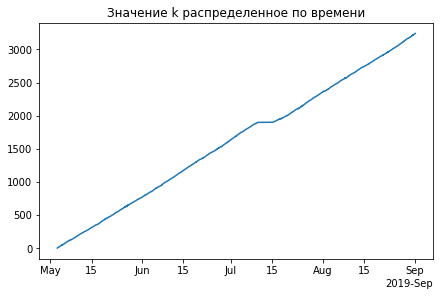

In [11]:
x = df_arc['start_heat']
y = df_arc['key']
title = 'Значение k распределенное по времени'
plot_time(x, y, title)

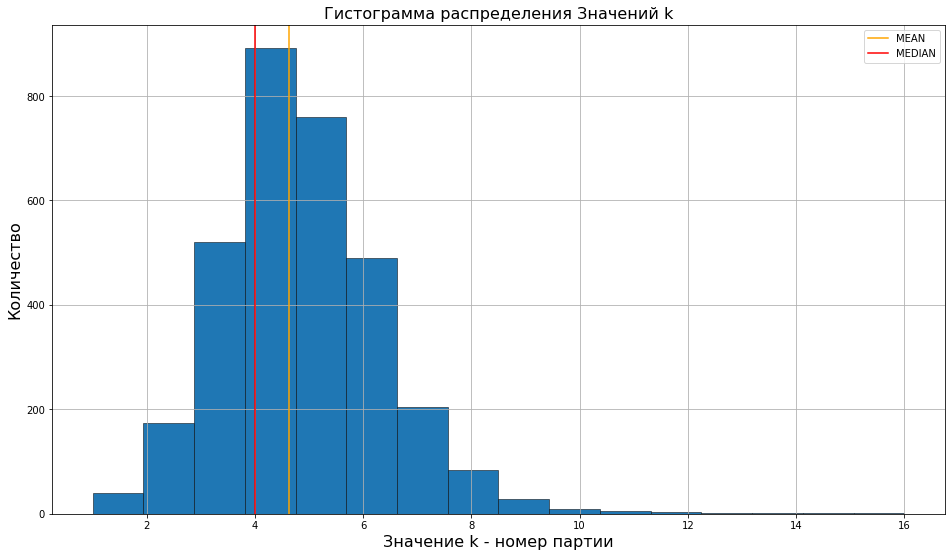


Среднее k: 4.628500311138768 (оранжевая линия)
Медианное k: 4.0 (красная линия)


In [12]:
#Calculating parameters
values = df_arc.groupby(['key'])['key'].count()
mean = values.mean()
median = values.median()
bins = len(values.unique())

#Plotting
plt.figure(figsize=(16,9))
plt.hist(values, bins=bins, linewidth=0.5, edgecolor='black')
plt.xlabel('Значение k - номер партии', fontsize=16)
plt.ylabel('Количество', fontsize=16)
plt.title('Гистограмма распределения Значений k', fontsize=16)
plt.axvline(x=mean, color='orange', label='MEAN')
plt.axvline(x=median, color='red', label='MEDIAN')
plt.legend()
plt.grid()
plt.show()

#Text
print()
print("Среднее k:", mean, '(оранжевая линия)')
print("Медианное k:", median, '(красная линия)')

Как видно из графиков, в промежутке между 9 и 16 сият "брешь в данных", то есть они не непрерывные. А так же у значения k "жирный хвост", то есть очень много выбросов в правой части нормального распределения k-значения. Увеличим масштаб интересующего нас места, а далее посмотрим на табличные данные

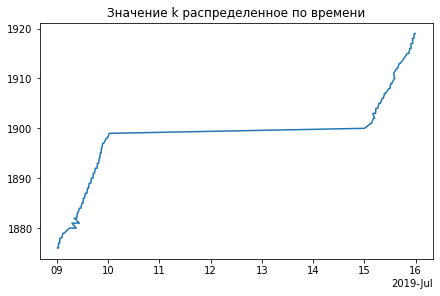

In [13]:
x = df_arc.query('"2019-07-16" >= start_heat >= "2019-07-09"')['start_heat']
y = df_arc.query('"2019-07-16" >= start_heat >= "2019-07-09"')['key']
title = 'Значение k распределенное по времени'
plot_time(x, y, title)

In [14]:
df_arc.query('"2019-07-15" > start_heat > "2019-07-10"')

,key,start_heat,end_heat,real_power,reactiv_power
8728,1899,2019-07-10 00:35:25,2019-07-10 00:37:32,0.416167,0.361145
8729,1899,2019-07-10 00:44:50,2019-07-10 00:53:11,2.071217,1.714313
8730,1899,2019-07-10 00:54:37,2019-07-10 00:57:52,0.872728,0.612388
8731,1899,2019-07-10 00:59:13,2019-07-10 01:02:36,0.910008,0.616204
8732,1899,2019-07-10 01:04:59,2019-07-10 01:05:55,0.242389,0.179130
8733,1900,2019-07-14 23:17:28,2019-07-14 23:18:44,0.261596,0.203939
8734,1900,2019-07-14 23:23:26,2019-07-14 23:27:21,0.770129,0.573527
8735,1900,2019-07-14 23:51:38,2019-07-14 23:56:09,0.908687,0.813689


4 дня пропавших данных, надо будет это учесть при дальнейшем анализе. Далее посмотрим на выбросы в распределении значения k. Для определения границ возможных принимаемых значений будем руководствоваться правилом трех сигм, для этого напишем функцию.

In [15]:
value_k = df_arc.groupby(['key'])['key'].count()
value_k.describe()

count    3214.000000
mean        4.628500
std         1.608647
min         1.000000
25%         4.000000
50%         4.000000
75%         6.000000
max        16.000000
Name: key, dtype: float64

In [16]:
def three_sigma(series):
    return list([round(series.mean() - 3 * series.std(), 2), round(series.mean() + 3 * series.std(), 2)])

In [17]:
list_range_k = three_sigma(value_k)

print('Для текущей выборки k должно находится в пределах:', list_range_k[0], '-', list_range_k[1])

Для текущей выборки k должно находится в пределах: -0.2 - 9.45


Пока изменять данные не будем, оставим этот вопрос на обсуждение с Тим-лидом.

In [18]:
df_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   key            14876 non-null  int64         
 1   start_heat     14876 non-null  datetime64[ns]
 2   end_heat       14876 non-null  datetime64[ns]
 3   real_power     14876 non-null  float64       
 4   reactiv_power  14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


Двигаемся дальше

 ### df_bulk


In [19]:
df_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [20]:
df_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


TODO:
1. изменить названия столбцов на англ.тип и строчные буквы
2. проверить на дубликаты

Напишем короткую функцию для приведения названий столбцов к нужному виду, и содержание столбцов к нужному типу, а так же заполнению пропусков.

In [21]:
def prepare_table(table, time_flag=0):
  '''
  Функция изменяет названия столбцов, приводит столбцы к нужному типу (если в
  таблице есть колонки с датами, и заполняет пропуски
  ''' 
  
  new_table = table.copy()
  new_table.columns = ['_'.join(str(x).lower().split()) for x in new_table.columns]

  if time_flag == 0:
    new_table = new_table.fillna(0)

  elif time_flag == 1:
    list_to_change_type = set(new_table.columns) - set(['key'])
    list_to_change_type = list(list_to_change_type)
    new_table[list_to_change_type] = new_table[list_to_change_type].astype('datetime64[ns]')
    new_table = new_table.fillna(pd.NaT)
  
  return new_table

In [22]:
df_bulk = prepare_table(df_bulk)

In [23]:
df_bulk.duplicated().sum()

0

Проверка

In [24]:
df_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   3129 non-null   float64
 2   bulk_2   3129 non-null   float64
 3   bulk_3   3129 non-null   float64
 4   bulk_4   3129 non-null   float64
 5   bulk_5   3129 non-null   float64
 6   bulk_6   3129 non-null   float64
 7   bulk_7   3129 non-null   float64
 8   bulk_8   3129 non-null   float64
 9   bulk_9   3129 non-null   float64
 10  bulk_10  3129 non-null   float64
 11  bulk_11  3129 non-null   float64
 12  bulk_12  3129 non-null   float64
 13  bulk_13  3129 non-null   float64
 14  bulk_14  3129 non-null   float64
 15  bulk_15  3129 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


 ### df_bulk_time

In [25]:
df_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [26]:
df_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


TODO:
1. изменить названия столбцов на англ.тип и строчные буквы
2. преобразовать тип столбцов к дате
3. проверить на дубликаты
4. Пропуски аналогично

In [27]:
df_bulk_time = prepare_table(df_bulk_time, 1)

In [28]:
df_bulk_time.duplicated().sum()

0

In [29]:
df_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   bulk_1   252 non-null    datetime64[ns]
 2   bulk_2   22 non-null     datetime64[ns]
 3   bulk_3   1298 non-null   datetime64[ns]
 4   bulk_4   1014 non-null   datetime64[ns]
 5   bulk_5   77 non-null     datetime64[ns]
 6   bulk_6   576 non-null    datetime64[ns]
 7   bulk_7   25 non-null     datetime64[ns]
 8   bulk_8   1 non-null      datetime64[ns]
 9   bulk_9   19 non-null     datetime64[ns]
 10  bulk_10  176 non-null    datetime64[ns]
 11  bulk_11  177 non-null    datetime64[ns]
 12  bulk_12  2450 non-null   datetime64[ns]
 13  bulk_13  18 non-null     datetime64[ns]
 14  bulk_14  2806 non-null   datetime64[ns]
 15  bulk_15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


 ### df_gas

In [30]:
df_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [31]:
df_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


Пропусков нет, TODO:
1. изменить названия столбцов на англ.тип и строчные буквы
2. проверить на дубликаты

In [32]:
df_gas.columns = ['key', 'gas_1']

In [33]:
df_gas.duplicated().sum()

0

In [34]:
df_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas_1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


Очень странно, что значений k в данной таблице на 100+ больше, чем в других. Проверим каких значений k нет в диапазоне от 1 до 3241 для каждой таблицы

In [35]:
list_k_all = list(range(1,3242))
tables = [df_arc, df_bulk, df_bulk_time, df_gas, df_wire, df_wire_time, df_temp]
tables_names = ['df_arc', 'df_bulk', 'df_bulk_time', 'df_gas', 'df_wire', 'df_wire_time', 'df_temp']

In [36]:
list_temp = []
dict_dif = {}
for table, name in zip(tables, tables_names):
  list_temp = table['key'].to_list()
  dif = [x for x in list_temp + list_k_all if x not in list_temp or x not in list_k_all]
  dict_dif[name] = dif
  print('В Таблице ', name, '\tне хватает:', len(dif), 'k-значений')

В Таблице  df_arc 	не хватает: 27 k-значений
В Таблице  df_bulk 	не хватает: 112 k-значений
В Таблице  df_bulk_time 	не хватает: 112 k-значений
В Таблице  df_gas 	не хватает: 2 k-значений
В Таблице  df_wire 	не хватает: 160 k-значений
В Таблице  df_wire_time 	не хватает: 160 k-значений
В Таблице  df_temp 	не хватает: 25 k-значений


Отлично, нашли еще одну аномалию в данных, что с ней делать мы решим дальше.

 ### df_temp

In [37]:
df_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [38]:
df_temp[df_temp['Температура'].isnull()].head(10)

,key,Время замера,Температура
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN
12274,2501,2019-08-06 04:22:14,NaN
12275,2501,2019-08-06 04:31:14,NaN
12277,2502,2019-08-06 04:46:04,NaN
12278,2502,2019-08-06 04:52:32,NaN
12279,2502,2019-08-06 04:57:30,NaN


In [39]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


TODO:
1. изменить названия столбцов на англ.тип и строчные буквы
2. преобразовать тип 2 столбца к дате
3. проверить на дубликаты

In [40]:
df_temp.columns = ['key', 'time_measure', 'temp']

In [41]:
df_temp['time_measure'] = df_temp['time_measure'].astype('datetime64')

In [42]:
df_temp.duplicated().sum()

0

In [43]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15907 non-null  int64         
 1   time_measure  15907 non-null  datetime64[ns]
 2   temp          13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


Судя по заданию, это и есть наш таргет, который необходимо предсказывать.
Пропуски удалим

In [44]:
df_temp = df_temp.loc[df_temp['key'] < 2500, :]

 ### df_wire

In [45]:
df_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
df_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


TODO:
1. изменить названия столбцов на англ.тип и строчные буквы
2. проверить на дубликаты

In [47]:
df_wire = prepare_table(df_wire)

In [48]:
df_wire.duplicated().sum()

0

In [49]:
df_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3081 non-null   float64
 2   wire_2  3081 non-null   float64
 3   wire_3  3081 non-null   float64
 4   wire_4  3081 non-null   float64
 5   wire_5  3081 non-null   float64
 6   wire_6  3081 non-null   float64
 7   wire_7  3081 non-null   float64
 8   wire_8  3081 non-null   float64
 9   wire_9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


 ### df_wire_time

In [50]:
df_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
df_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


TODO:
1. изменить названия столбцов на англ.тип и строчные буквы
2. преобразовать тип столбцов к дате
3. проверить на дубликаты
4. пропуски

In [52]:
df_wire_time = prepare_table(df_wire_time, 1)

In [53]:
df_wire_time.duplicated().sum()

0

In [54]:
df_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   wire_1  3055 non-null   datetime64[ns]
 2   wire_2  1079 non-null   datetime64[ns]
 3   wire_3  63 non-null     datetime64[ns]
 4   wire_4  14 non-null     datetime64[ns]
 5   wire_5  1 non-null      datetime64[ns]
 6   wire_6  73 non-null     datetime64[ns]
 7   wire_7  11 non-null     datetime64[ns]
 8   wire_8  19 non-null     datetime64[ns]
 9   wire_9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


### Вывод

Первично данные осмотрены, выявлены места, требующие уточнений.
Не удобно работать с такой кучей таблиц, их надо как-то объединить.

---

# Часть 2 Доочищение данных и формирование итоговой таблицы

Итак после обсуждения задачи с Тим-лидом и Заказчиком, пришла ясность в данной задаче, нужно сформировать итоговую таблицу, которая будет содержать: начальную температуру, прилагаемую активную мощность, присадки, конечную температуру(таргет). Вся изюминка в том, что данные по присадкам разбросаны по времени, и есть множество записей, когда присдаки добавляли до начальной температуры или после конечной. Такие данные надо обнулить. Так же есть множество промежуточных температур, которые для данной задачи являются излишними. И задача не сводится к времянным рядам, как изначально подсказывала интуиция.

Вопросы, которые возникли в первой части:
1. Что делать с разрывом в 4 дня в данных ?
  - не обращать на него внимание, это задача обычная регрессия.

2. Что делать с выбрасами k?
  - оставить, как есть. Такие данные от Заказчика, и это не выбросы.

3. Что делать с разным количество k ?
  - удалить "лишние", отталкиваться от таблицы температур. В этом случае удалиться 2 партии из df_arc и максимум 25 значений из других таблиц. То что в таблицах "присадок" нет нужного количества данных неважно, допустим, что часть партий была изначально хорошего химического состава и их только обработали газом.

## df_temp

Итак нужно доочищать данные, а так же свести все в одну таблицу. Этим и займемся, начнем с таблицы df_temp, но сначала разберемся с разными значениями k в данной таблице и в таблице df_arc

In [55]:
set(dict_dif['df_arc']) - set(dict_dif['df_temp'])

{195, 279}

In [56]:
df_temp[df_temp['key'] == 195]

,key,time_measure,temp
1100,195,2019-05-10 14:10:23,1583.0


In [57]:
df_temp[df_temp['key'] == 279]

,key,time_measure,temp
1554,279,2019-05-13 23:07:28,1603.0


Как видно для данных значений партий есть только начальная температура, а так как эти данные относятся к выборке train, то предлагается их удалить из-за не полноты данных.

In [58]:
df_temp = df_temp.drop(index=[df_temp[df_temp['key'] == 195].index[0], df_temp[df_temp['key'] == 279].index[0]])

Теперь удалим промежуточные значения температур, оставим только начальную и конечную

In [59]:
keys = df_temp['key'].unique()
list_to_delete = []

for key in keys:
  list_to_delete += list(set(df_temp[df_temp['key'] == key].index) - set([df_temp[df_temp['key'] == key].idxmin().values[1], df_temp[df_temp['key'] == key].idxmax().values[1]]))

Список "лишних" строк в таблице получили, теперь удалим их.

In [60]:
df_temp = df_temp.drop(index=list_to_delete)
df_temp.head()

,key,time_measure,temp
0,1,2019-05-03 11:16:18,1571.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
10,2,2019-05-03 11:59:12,1602.0
11,3,2019-05-03 12:13:17,1596.0


Отлично удалили лишние данные, теперь четко видно начальную и конечные температуры. Создадим итоговую таблицу df и начнем ее наполнять

In [61]:
df = pd.DataFrame()

In [62]:
df['target'] = df_temp['temp'].values[1::2]

In [63]:
df['start_temp'] = df_temp['temp'].values[0::2]

In [64]:
df['key'] = df_temp['key'].unique()

Посмотрим, что получилось

In [65]:
df.head()

,target,start_temp,key
0,1613.0,1571.0,1
1,1602.0,1581.0,2
2,1599.0,1596.0,3
3,1625.0,1601.0,4
4,1602.0,1576.0,5


---

## df_arc

Отформатируем таблицу **df_arc** и добавим необходимые данные из нее в итоговую таблицу

In [66]:
list_add_before = []
list_add_after = []
keys = df_temp['key'].unique()
time_col_arc = ['start_heat', 'end_heat']

for key in keys:
  for row_data, index_data in zip(df_arc[df_arc['key'] == key][time_col_arc].values, df_arc[df_arc['key'] == key][time_col_arc].index):
    for value in row_data:
      if value < df_temp[df_temp['key'] == key]['time_measure'].min():
        list_add_before.append(index_data)
      elif value > df_temp[df_temp['key'] == key]['time_measure'].max():
        list_add_after.append(index_data)

list_to_delete_2 = pd.Series(list_add_before + list_add_after).unique()

In [67]:
df_arc = df_arc.drop(index=list_to_delete_2)

Лишние мощности удалили, которые были до начальной температуры и после нее. Теперь сгруппируем таблицу и присоединим сумму активных мощностей для каждой партии к итоговой таблице.

In [68]:
df_arc_group = pd.DataFrame(df_arc.groupby('key')['real_power'].sum().reset_index())
df_arc_group.head(10)

,key,real_power
0,1,2.352117
1,2,2.614535
2,3,1.463829
3,4,1.220955
4,5,1.889121
5,6,3.620968
6,7,2.160290
7,8,1.672854
8,9,1.572590
9,10,2.453327


Теперь присоединим эти данные к итоговой таблице

In [69]:
df = df.merge(df_arc_group, how='left', on='key')
df.head(10)

,target,start_temp,key,real_power
0,1613.0,1571.0,1,2.352117
1,1602.0,1581.0,2,2.614535
2,1599.0,1596.0,3,1.463829
3,1625.0,1601.0,4,1.220955
4,1602.0,1576.0,5,1.889121
5,1596.0,1543.0,6,3.620968
6,1599.0,1586.0,7,2.160290
7,1598.0,1577.0,8,1.672854
8,1592.0,1587.0,9,1.572590
9,1593.0,1574.0,10,2.453327


Естественно образовались пропуски, так как значения партий разное в таблицах, пропуски заменим средней мощностью, а так же все выбросы.

In [70]:
df.isna().sum()

target         0
start_temp     0
key            0
real_power    34
dtype: int64

In [71]:
list_range_power = three_sigma(df['real_power'])

print('Для текущей выборки power должно находится в пределах:', list_range_power[0], '-', list_range_power[1])

Для текущей выборки power должно находится в пределах: -1.57 - 6.66


In [72]:
new_mean_value_power = df['real_power'][df['real_power'] < list_range_power[1]].mean()
df.loc[df['real_power'] > list_range_power[1], 'real_power'] = new_mean_value_power
df['real_power'] = df['real_power'].fillna(new_mean_value_power)

Проверка

In [73]:
df.isna().sum()

target        0
start_temp    0
key           0
real_power    0
dtype: int64

---

## df_gas

Теперь перейдем к таблице **df_gas**

In [74]:
df = df.merge(df_gas, how='left', on='key')
df.head()

,target,start_temp,key,real_power,gas_1
0,1613.0,1571.0,1,2.352117,29.749986
1,1602.0,1581.0,2,2.614535,12.555561
2,1599.0,1596.0,3,1.463829,28.554793
3,1625.0,1601.0,4,1.220955,18.841219
4,1602.0,1576.0,5,1.889121,5.413692


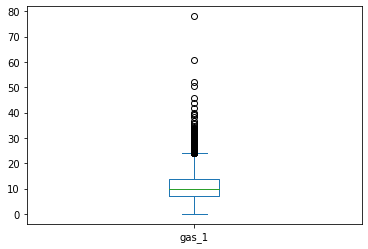

In [75]:
df['gas_1'].plot(kind='box')

In [76]:
list_range_gas = three_sigma(df_gas['gas_1'])

print('Для текущей выборки gas должно находится в пределах:', list_range_gas[0], '-', list_range_gas[1])

Для текущей выборки gas должно находится в пределах: -7.66 - 29.66


In [77]:
df['gas_1'].isna().sum()

2

In [78]:
new_mean_value_gas = df['gas_1'][df['gas_1'] < list_range_gas[1]].mean()
df.loc[df['gas_1'] > list_range_gas[1], 'gas_1'] = new_mean_value_gas
df['gas_1'] = df['gas_1'].fillna(new_mean_value_gas)

Проверка

In [79]:
df.isna().sum()

target        0
start_temp    0
key           0
real_power    0
gas_1         0
dtype: int64

---

## df_bulk & df_bulk_time

Перейдем к таблицам **df_bulk & df_bulk_time**. Так принцип поиска, зануления данных, присоединения, а также заполнения пропусков для данной пары таблиц и для пары таблиц **df_wire & df_wire** одинаковый, то напишем функцию для этих операций

In [80]:
def transform_table(input_tb_time, input_tb_data, search_tb_time, 
                    finish_tb, col_name, name):
  '''
  Функция делает четыре операции:
  1. В search_tb_time для каждой партии key ищет границы интервала времени,
  далее в таблице input_tb_time проверяет все значения на вхождение в данный 
  интервал, для той же партии k. Любые значения вне итервала записывает в словарь, 
  где ключ = индекс input_tb_time,
  значение = название столбца.
  2. Согласно полученого словаря в таблице input_tb_data зануляет данные, таблицы
  input_tb_data и input_tb_time - одинаковые по размерам, различаются только 
  данными.
  3. Суммирирует оставшиеся значения в input_tb_data для каждой партии и данный 
  столбец левым джойном присоединяет к finish_tb.
  4. Заполняет пропуски нулями в finish_tb и возвращает ее.
  '''
  # Подготовка
  dict_to_zero = {}
  input_table_time = input_tb_time.copy()
  input_table_data = input_tb_data.copy()
  search_table_time = search_tb_time.copy()
  finish_table = finish_tb.copy()
  keys = input_table_time['key'].unique()  

  # Операция 1 

  for key in keys:
    for row_data, index_data in zip(input_table_time[input_table_time['key'] == key][col_name].values, input_table_time[input_table_time['key'] == key][col_name].index):
      dict_to_zero[index_data] = []
      for value, i in zip(row_data, list(range(0, len(col_name)))):
        if value < search_table_time[search_table_time['key'] == key]['time_measure'].min():
          dict_to_zero[index_data].append(col_name[i])
        elif value > search_table_time[search_table_time['key'] == key]['time_measure'].max():
          dict_to_zero[index_data].append(col_name[i])

  # Операция 2
  for kluch in dict_to_zero:
    if len(dict_to_zero[kluch]) != 0:
      for col in dict_to_zero[kluch]:
        input_table_data.loc[kluch, col] = 0
    else:
      None

  # Операция 3

  input_table_data[name + '_all'] = input_table_data[col_name].sum(axis=1)
  finish_table = finish_table.merge(input_table_data[['key', name +'_all']], how='left', on='key')

  # Операция 4
  finish_table[name + '_all'] = finish_table[name + '_all'].fillna(0)

  return finish_table

In [81]:
time_col_bulk = ['bulk_'+str(i) for i in range(1,16)]

In [82]:
df = transform_table(df_bulk_time, df_bulk, df_temp, df, time_col_bulk, 'bulk')

Проверка

In [83]:
df.head()

,target,start_temp,key,real_power,gas_1,bulk_all
0,1613.0,1571.0,1,2.352117,10.714820,43.0
1,1602.0,1581.0,2,2.614535,12.555561,582.0
2,1599.0,1596.0,3,1.463829,28.554793,34.0
3,1625.0,1601.0,4,1.220955,18.841219,0.0
4,1602.0,1576.0,5,1.889121,5.413692,0.0


In [84]:
df.isna().sum()

target        0
start_temp    0
key           0
real_power    0
gas_1         0
bulk_all      0
dtype: int64

Отлично, движемся дальше

---

## df_wire & df_wire_time

In [85]:
time_col_wire = ['wire_'+str(i) for i in range(1,10)]

In [86]:
df = transform_table(df_wire_time, df_wire, df_temp, df, time_col_wire, 'wire')

Проверка

In [87]:
df.head()

,target,start_temp,key,real_power,gas_1,bulk_all,wire_all
0,1613.0,1571.0,1,2.352117,10.714820,43.0,0.000000
1,1602.0,1581.0,2,2.614535,12.555561,582.0,96.052315
2,1599.0,1596.0,3,1.463829,28.554793,34.0,91.160157
3,1625.0,1601.0,4,1.220955,18.841219,0.0,0.000000
4,1602.0,1576.0,5,1.889121,5.413692,0.0,9.114560


In [88]:
df.isna().sum()

target        0
start_temp    0
key           0
real_power    0
gas_1         0
bulk_all      0
wire_all      0
dtype: int64

Приведем таблицу в приятный вид, когда таргет является последней колонкой и колонку key сделаем индексом

In [89]:
df = df[['key', 'start_temp', 'real_power', 'gas_1', 'bulk_all', 'wire_all', 'target']]
df = df.set_index(['key'])
df.head()

,start_temp,real_power,gas_1,bulk_all,wire_all,target
key,,,,,,
1,1571.0,2.352117,10.714820,43.0,0.000000,1613.0
2,1581.0,2.614535,12.555561,582.0,96.052315,1602.0
3,1596.0,1.463829,28.554793,34.0,91.160157,1599.0
4,1601.0,1.220955,18.841219,0.0,0.000000,1625.0
5,1576.0,1.889121,5.413692,0.0,9.114560,1602.0


Проверим на корреляцию наши данные

In [90]:
df.corr()

,start_temp,real_power,gas_1,bulk_all,wire_all,target
start_temp,1.000000,-0.278500,-0.024765,0.019271,0.058410,0.376621
real_power,-0.278500,1.000000,0.323521,0.498592,0.105091,0.268465
gas_1,-0.024765,0.323521,1.000000,0.288202,0.204236,-0.028390
bulk_all,0.019271,0.498592,0.288202,1.000000,0.226010,0.039851
wire_all,0.058410,0.105091,0.204236,0.226010,1.000000,-0.154947
target,0.376621,0.268465,-0.028390,0.039851,-0.154947,1.000000


Наиболее сильно зависимость таргета видна от начальной температуры и мощности, остальные признаки практически не влияют на конечную температуру. Но это проверялась линейная зависимость, а возможно нелинейное воздействие на конечную температуру присадок.

## Вывод

Итак EDA этап закончен, по итогам сформирована итоговая таблица, включающая все необходимые отфильтрованные данные. Можно приступать к машинному обучению

# Часть 3 Машинное обучение

## Разбиение и подготовка данных для обучения

Полученный датасет разделим на три части: 60/20/20

In [91]:
df_train = df.loc[:1499, :]
df_valid = df.loc[1500:1999, :]
df_test = df.loc[2000:, :]
features_train = df_train.drop(['target'], axis=1)
target_train = df_train['target']
features_valid = df_valid.drop(['target'], axis=1)
target_valid = df_valid['target']
features_test = df_test.drop(['target'], axis=1)
target_test = df_test['target']
print('Train =', features_train.shape, target_train.shape)
print('Valid =', features_valid.shape, target_valid.shape)
print('Test  =', features_test.shape, target_test.shape)

Train = (1483, 5) (1483,)
Valid = (500, 5) (500,)
Test  = (492, 5) (492,)


In [92]:
features_valid.head()

,start_temp,real_power,gas_1,bulk_all,wire_all
key,,,,,
1500,1596.0,4.988978,25.685625,1068.0,114.145203
1501,1578.0,2.419567,8.872583,747.0,0.000000
1502,1556.0,4.098190,16.384768,729.0,142.239765
1503,1525.0,4.878081,18.652141,311.0,95.181835
1504,1545.0,2.545666,9.607781,512.0,134.853682


Так как у нас только числовые признаки масштабируем их

In [93]:
scaler = StandardScaler()
scaler.fit(features_train) 
features_train = scaler.transform(features_train)
features_valid = scaler.transform(features_valid)
features_test = scaler.transform(features_test)

## Обучение моделей

Рассмотрим три модели:
* Catboost
* Linreg
* RandomForest

Сначала сравним показание метрики при стандартных настройках, потом выберем лучшую модель и через GridSearch/optuna постараемся улучшить метрику нашей выбранной модели. Результаты будем заносить в таблицу

In [94]:
result_df = pd.DataFrame(columns=['MAE'])
result_df.index.name='name_ml'

### CatBoost

In [95]:
cat_model = cb.CatBoostRegressor(random_seed=101, 
                                 early_stopping_rounds=20, 
                                 loss_function = 'MAE',
                                 silent=True)

cat_model.fit(features_train, target_train, eval_set=(features_valid, target_valid))
cat_pred = cat_model.predict(features_valid)
result_df.loc['CatBoost'] = [round(mean_absolute_error(target_valid, cat_pred), 3)]
display(result_df)

,MAE
name_ml,
CatBoost,6.633


### Linreg

In [96]:
lr_model = LinearRegression()
lr_model.fit(features_train, target_train)
lr_pred = lr_model.predict(features_valid)
result_df.loc['LR'] = [round(mean_absolute_error(target_valid, lr_pred), 3)]
display(result_df)

,MAE
name_ml,
CatBoost,6.633
LR,8.635


### RandomForest

In [97]:
rf_model = RandomForestRegressor(criterion='absolute_error',
                                 random_state = 101)
rf_model.fit(features_train, target_train)
rf_pred = rf_model.predict(features_valid)
result_df.loc['RF'] = [round(mean_absolute_error(target_valid, rf_pred), 3)]
display(result_df)

,MAE
name_ml,
CatBoost,6.633
LR,8.635
RF,6.901


Как видно с данным набором лучше работает Catboost. Попробуем добиться еще прироста метркии подобрав параметры

## Выбор модели и улучшение метрики

Для подбора параметров воспользуемся **optuna**

In [98]:
def objective(trial):
    param = {}
    param['learning_rate'] = trial.suggest_discrete_uniform("learning_rate", 0.001, 0.02, 0.001)
    param['depth'] = trial.suggest_int('depth', 9, 12)
    param['l2_leaf_reg'] = trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.5, 0.5)
    param['min_child_samples'] = trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])
    param['grow_policy'] = 'Depthwise'
    param['iterations'] = 10000
    param['use_best_model'] = True
    param['eval_metric'] = 'MAE'
    param['od_type'] = 'iter'
    param['od_wait'] = 20
    param['random_state'] = 101
    param['logging_level'] = 'Silent'
    
    regressor = cb.CatBoostRegressor(**param)

    regressor.fit(features_train, target_train,
                  eval_set=(features_valid, target_valid),
                  early_stopping_rounds=20)
    loss = mean_absolute_error(target_test, regressor.predict(features_test))
    return loss

In [99]:
%%time
study = optuna.create_study(study_name=f'catboost-seed{101}')
study.optimize(objective, n_trials=10000, n_jobs=-1, timeout=900)

[I 2022-06-23 05:51:32,000] A new study created in memory with name: catboost-seed101
/usr/local/lib/python3.7/dist-packages/optuna/study/study.py:397: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  FutureWarning,
[I 2022-06-23 05:52:06,656] Trial 1 finished with value: 6.815256068008473 and parameters: {'learning_rate': 0.02, 'depth': 11, 'l2_leaf_reg': 4.5, 'min_child_samples': 1}. Best is trial 1 with value: 6.815256068008473.
[I 2022-06-23 05:52:15,611] Trial 2 finished with value: 6.6627185228853225 and parameters: {'learning_rate': 0.009000000000000001, 'depth': 9, 'l2_leaf_reg': 4.0, 'min_child_samples': 32}. Best is trial 2 with value: 6.6627185228853225.
[I 2022-06-23 05:52:24,106] Trial 0 finished with value: 6.801534296189211 and parameters: {'learning_rate': 0.016, 'depth': 12, 'l2_leaf_reg': 4.5, 'min_child_samples': 1}. Best is trial 2 with value: 6.6627185

CPU times: user 32min 25s, sys: 1min 56s, total: 34min 21s
Wall time: 17min 34s


In [100]:
study.best_value

6.6073337109199475

In [101]:
study.best_params

{'depth': 10,
 'l2_leaf_reg': 3.5,
 'learning_rate': 0.005,
 'min_child_samples': 16}

Удалось улучшить метрику на 3 сотых на тестовой выборке.

## Вывод

Рассмотрели три различных модели, лучшую метрику показал Catboost с результатом 6,6.

# Часть 4 Вывод

В данной работе необходимо было построить модель для предсказания температуры стали на выходе партии после добавления присадок с заданной погрешностью **MAE < 6.8**.

Поставленную задачу удалось выполнить после тщательного исследовательского анализа данных и их подговтовки с помощью модели машинного обучения Catboost с результатом **MAE = 6.6**. Так же дополнительно были рассмотрены и другие модели машинного обучения: LinearRegression и RandomForest, но они показали худшие результаты.

В ходе работы было выявленно, что наибольшая зависимость конечной температуры от начальной температуры и прилагаемой мощности к нагреву, что естественно и не противоречит логике с физикой.

Так же в исследовательском этапе были найдены следующие явления, требующие своего внимания:
- Отсутствие данных между 10 и 14 июля, об этом не было предупреждения от Заказчика. Но так как решение не было основано на времянных рядах, это никак не повлияло на результат.
- Есть целая группа партий с большим количеством итераций по добавлению присадок и соответствующим нагревом. На мой взгляд стоит обратить на это пристальное внимание, так как тут есть, что оптимизировать, сократив тем самым издержки производства.
- Так же большое количество данных об обработке газом, выбивается из средних/медианных значений.

Основной трудностью на мой взгляд была не четко сформулированная задача Заказчиком, пришлось задавать множество уточняющих вопросов, чтобы понять какие данные нужны для решения поставленной задачи. Чуть меньшей проблемой, но ключевой для решения, было из представленного набора данных сформировать итоговую таблицу пригодную для машинного обучения.